In [2]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [78]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

### Salaris
sal_feh = afunc.sal(r13['M_H'],r13['ALPHA_M'])

In [5]:
parsec.columns

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

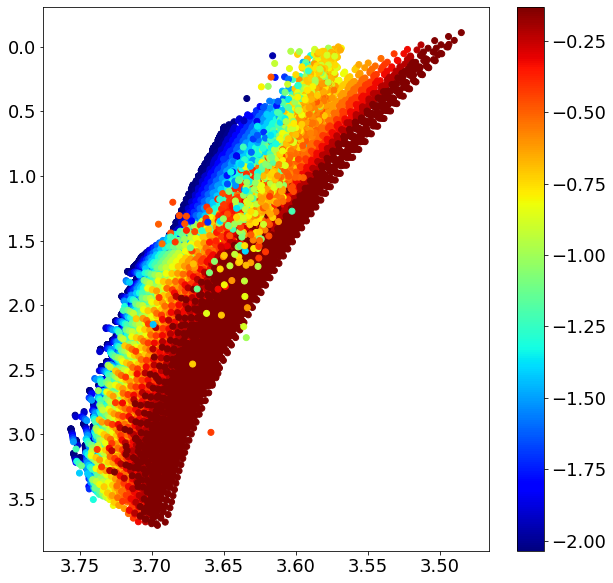

In [88]:
plt.figure(figsize=[10,10])
plt.scatter(parsec['logTe'],parsec['logg'],c=parsec['MH'],cmap='jet',vmax=max(sal_feh),
            vmin=min(sal_feh))
plt.colorbar()
plt.scatter(np.log10(r13['TEFF']),r13['LOGG'],c=r13['FE_H'],cmap='jet')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [45]:
metr = []
for i in tqdm_notebook(range(len(r13)),desc='Done?'):
    r13arr = np.array([np.log10(r13['TEFF'][i]),r13['K'][i],r13['FE_H'][i],r13['LOGG'][i]])
    nr13arr = np.linalg.norm(r13arr)
    
    sims = []
    for j in range(len(parsec)):
        pararr = np.array([parsec['logTe'][j],parsec['Ksmag'][j],parsec['MH'][j],parsec['logg'][j]])
        
        sims.append(np.dot(r13arr, pararr)/(nr13arr*np.linalg.norm(pararr)))
        
    metr.append(sims)

In [71]:
ang_sim = np.subtract(1.,np.arccos(metr[1000])/np.pi).tolist()
s_ang_sim = sorted(ang_sim)

In [72]:
np.where(np.asarray(ang_sim)<=s_ang_sim[3])

(array([14289, 14868, 14869, 14945]),)

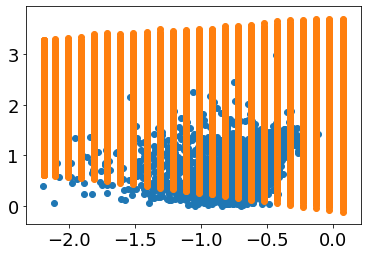

In [86]:
plt.scatter(r13['FE_H'],r13['LOGG'])
plt.scatter(parsec['MH'],parsec['logg'])

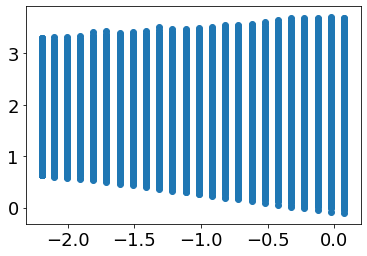

In [85]:
plt.scatter(parsec['MH'],parsec['logg'])